In [1]:
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import linalg
from copy import deepcopy

In [2]:
def int2onehot(n, max_n):
    res = np.zeros(max_n)
    res[n] = 1.
    return res

In [3]:
num_frames = 2
max_steps = 2000
num_games = 200

In [4]:
def dim_reduce(a, V, keep_dim):
    res = np.zeros([keep_dim])
    for i in xrange(keep_dim):
        res[i] = np.matmul(a, V[i])
    return res

In [5]:
def red_train_agent2(training_epochs,red_games, commulative_rewards_np):
    merged_summary = tf.summary.merge_all()
    mx = commulative_rewards_np.max()
    mean = commulative_rewards_np.mean()
    amplitude = commulative_rewards_np.max() - commulative_rewards_np.min()
    step = 1
    for red_game, reward in zip(red_games, commulative_rewards_np):
        step += 1
        actions = np.array([_[1] for _ in red_game])
        observations = np.array([_[0] for _ in red_game])
        l = len(observations)
        for n in xrange(training_epochs):
            grads_buff = sess.run(red_grads, feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32),
                                                   red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})
            c = (reward - mean) / mean
            sess.run(red_apply_grads, \
                feed_dict={red_grad1_ph:(c * grads_buff[0][0]), \
                                red_grad2_ph:(c * grads_buff[1][0]), \
                               red_grad3_ph:(c * grads_buff[2][0]), \
                               red_grad4_ph:(c * grads_buff[3][0])})

In [6]:
def play_random(num_games, max_steps, render):
    games = deque()
    env = gym.make("DemonAttack-ram-v3")
    commulative_rewards = deque()
    for i in xrange(num_games):
        #comp_observation = deque(maxlen = 3)
        observation = np.array(env.reset())
        comp_observation = deepcopy(observation) 
        comp_observations = deque()
        actions = deque()
        current_game = deque()
        commulative_reward = 0
        for j in xrange(max_steps):
            if render:
                env.render()            
            old_observation = observation
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            if len(comp_observation) == num_frames * 128:
                comp_observations.append(deepcopy(comp_observation))
            comp_observation = np.hstack((comp_observation, deepcopy(old_observation)))[-num_frames * 128:]
            commulative_reward += reward
            if(len(comp_observation) == num_frames * 128):
                current_game.append((comp_observation, int2onehot(action, env.action_space.n), reward))
                actions.append(int2onehot(action, env.action_space.n))
                comp_observations.append(comp_observation)
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [7]:
def red_play(num_games, max_steps, render, V):
    games = deque()
    actions = [ _ for _ in xrange(0, 6)]
    env = gym.make("DemonAttack-ram-v3")
    commulative_rewards = deque()
    for i in xrange(num_games):
        observation = env.reset()
        comp_observation = deepcopy(observation)
        current_game = deque()
        commulative_reward = 0
        for j in xrange(max_steps):
            if render:
                env.render()
            if len(comp_observation) == num_frames * 128:
                #print "red_play: random_choice(probabilities)", len(comp_observation)
                red_observation = dim_reduce(comp_observation, V, red_Din)
                probabilities = sess.run(red_y, \
                                     feed_dict={red_x:red_observation.reshape([1, \
                                        len(red_observation)]).astype(dtype=np.float32)})
                action = np.random.choice(a=actions, p=probabilities[0])
                observation, reward, done, info = env.step(action)
                current_game.append((red_observation, int2onehot(action, env.action_space.n), reward))
            else:
                #print "red_play: action_space.sample:", len(comp_observation)
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
            commulative_reward += reward
            
            comp_observation = np.hstack((comp_observation, observation))[-num_frames * 128:]
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [8]:
games, commulative_rewards = play_random(num_games=num_games, max_steps=2000, render=False)
commulative_rewards_np = np.array(commulative_rewards)

[2017-08-08 20:27:24,190] Making new env: DemonAttack-ram-v3


159.7


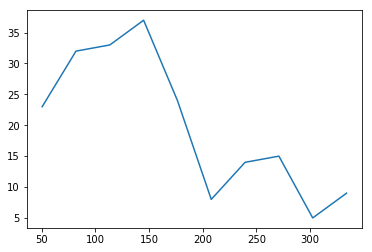

In [9]:
rewards_np = np.array( [_ for _ in commulative_rewards], dtype=np.float )
print rewards_np.mean()
h = np.histogram(rewards_np)
plt.plot(h[1][:len(h[1]) - 1] + 10.5, h[0])
plt.show()

In [10]:
game = games[commulative_rewards_np.argmax()]
commulative_reward = commulative_rewards[commulative_rewards_np.argmax()]
print game[0], commulative_reward
print game[0][0], game[0][1], game[0][2]

(array([  1, 171,   0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,
         0,   0, 216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,
         4,   1,  64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,
         1,   0,   0,   0,   0,   0,   0,   3,   0,  62,   1,  51,  40,
        30,  40,  30,  76, 134, 106,  76,   0,   0,   0, 128,   0, 182,
        31,   0,   0, 255,  44,  86,  76, 220,  66,  14,   8,  64,   1,
       192,   0, 100,  31, 110,  31, 120,  31, 130,  31, 140,  31, 128,
        31, 255,   1, 128,   4,   0,   3,   0,   1,   0,   0,   0,   0,
         0,   0, 140,   0, 188,   0,   0,  36,  28, 135,  19,   1, 171,
         0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,   0,   0,
       216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,   4,   1,
        64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,  

In [11]:
observations = np.array([_[0] for _ in game], dtype=np.float)

In [12]:
U, s, V = linalg.svd(observations[1:], full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True, lapack_driver='gesdd')

In [13]:
print s

[  6.34541947e+04   8.24313494e+03   7.97514400e+03   6.76129421e+03
   5.59195370e+03   5.38464256e+03   5.04189537e+03   4.97425002e+03
   4.83169036e+03   4.65993667e+03   4.51439293e+03   4.31338974e+03
   4.09841791e+03   4.06032848e+03   3.90131476e+03   3.68515754e+03
   3.59019288e+03   3.46351817e+03   3.41477464e+03   3.34366175e+03
   3.32937619e+03   3.22795105e+03   3.12837197e+03   3.01698794e+03
   2.92931233e+03   2.91265323e+03   2.84969927e+03   2.83509542e+03
   2.74973599e+03   2.73766590e+03   2.65277341e+03   2.61622286e+03
   2.57363902e+03   2.55797447e+03   2.52148966e+03   2.47587926e+03
   2.45776637e+03   2.44502945e+03   2.35335807e+03   2.29969895e+03
   2.28565058e+03   2.24630982e+03   2.16767706e+03   2.10412926e+03
   2.09186390e+03   1.99129856e+03   1.94365927e+03   1.90891729e+03
   1.86921496e+03   1.83952661e+03   1.69269454e+03   1.59717904e+03
   1.50308036e+03   1.39158446e+03   1.32779308e+03   1.32186896e+03
   1.28748798e+03   1.22605188e+03

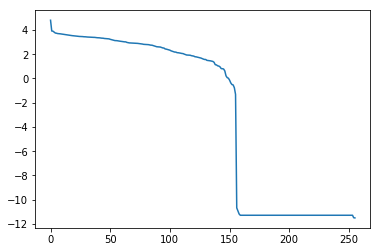

In [14]:
plt.plot(np.log10(s))
plt.show()

In [15]:
lr = 1e-5
training_epochs = 1
D_hid1 = 150
D_hid2 = 60
red_Din = 160
Din = 128
Dout = 6

In [16]:
sess = tf.Session()

In [17]:
red_x = tf.placeholder(tf.float32, [None, red_Din], name="red_x")

red_grad1_ph = tf.placeholder(tf.float32, name="red_grad1_ph")
red_grad2_ph = tf.placeholder(tf.float32, name="red_grad2_ph")
red_grad3_ph = tf.placeholder(tf.float32, name="red_grad3_ph")
red_grad4_ph = tf.placeholder(tf.float32, name="red_grad4_ph")


red_W1 = tf.Variable(tf.random_normal([red_Din, D_hid1], stddev=0.0001), name="red_W1")
red_b1 = tf.Variable(tf.random_normal([D_hid1], stddev=0.0001), name="red_b1") 

red_W = tf.Variable(tf.random_normal([D_hid1, Dout], stddev=0.0001), name="red_W")
red_b = tf.Variable(tf.random_normal([Dout], stddev=0.0001), name="red_b")

red_H = tf.nn.relu(tf.matmul(red_x, red_W1) + red_b1)
red_y = tf.nn.softmax(tf.matmul(red_H, red_W) + red_b)
#red_y = tf.nn.softmax(tf.matmul(red_x, red_W) + red_b, name = "red_y")
red_y_ = tf.placeholder(tf.float32, [None, Dout], name="red_y_")

In [18]:
#red_cross_entropy = tf.reduce_mean(-tf.reduce_sum(red_y_ * tf.log(red_y), reduction_indices=[1]))
red_square_loss = tf.reduce_mean(tf.pow(red_y_ - red_y, 2))

In [19]:
red_adam = tf.train.AdamOptimizer(learning_rate=lr)

#tvars = tf.trainable_variables()
red_tvars = [red_W, red_b, red_W1, red_b1]

red_grads = red_adam.compute_gradients(loss=red_square_loss, var_list=red_tvars)
red_apply_grads = red_adam.apply_gradients(zip([red_grad1_ph, red_grad2_ph, red_grad3_ph, red_grad4_ph],red_tvars))

In [20]:
sess.run(tf.global_variables_initializer())

In [21]:
rewards = np.ndarray([0], dtype=np.float32)

[2017-08-08 20:31:24,482] Making new env: DemonAttack-ram-v3


Iteration: 1 / 1


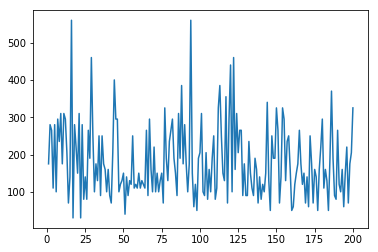

In [22]:
num_iterations = 1
for i in xrange(num_iterations):
    print "Iteration:", i + 1, '/', num_iterations
    red_games, commulative_rewards = red_play(num_games=num_games, max_steps=3000, render=False, V=V)
    commulative_rewards_np = np.array(commulative_rewards)
    rewards = np.hstack((rewards, commulative_rewards_np))
    x = np.linspace(1, len(rewards), len(rewards))
    plt.plot(x, rewards)
    plt.show()
    red_train_agent2(1, red_games, commulative_rewards_np)

In [23]:
g, r = red_play(num_games=1, max_steps=5000, render=True, V=V)

[2017-08-08 20:46:17,580] Making new env: DemonAttack-ram-v3


In [24]:
def onehot2int(v):
    for _ in range(len(v)):
        if v[_] == 1:
            return _
    return len(v)

In [25]:
actions = deque()
onehot2int(red_games[0][0][1])
actions = deque()
for game in games:
    for step in game:
        actions.append(onehot2int(step[1]))

In [26]:
print actions

deque([4, 5, 0, 3, 3, 3, 1, 3, 5, 2, 4, 0, 0, 4, 2, 1, 0, 1, 5, 1, 5, 0, 1, 4, 3, 0, 3, 5, 0, 2, 3, 0, 1, 3, 5, 3, 3, 0, 1, 1, 1, 0, 2, 4, 3, 3, 2, 4, 2, 0, 0, 4, 5, 5, 0, 4, 1, 4, 1, 2, 2, 0, 1, 1, 1, 1, 3, 3, 2, 3, 0, 3, 5, 4, 1, 2, 4, 3, 4, 4, 4, 3, 4, 4, 4, 0, 4, 3, 2, 5, 5, 5, 0, 1, 5, 1, 3, 0, 5, 0, 1, 2, 4, 2, 0, 5, 3, 2, 2, 5, 0, 5, 1, 0, 2, 2, 3, 2, 3, 2, 1, 2, 3, 3, 3, 2, 3, 4, 1, 2, 3, 1, 2, 1, 4, 2, 3, 0, 3, 2, 3, 0, 0, 0, 3, 2, 3, 0, 4, 0, 5, 0, 5, 2, 3, 2, 3, 5, 0, 0, 0, 3, 0, 2, 2, 0, 4, 3, 4, 5, 0, 4, 3, 5, 3, 4, 5, 1, 5, 3, 0, 0, 0, 5, 5, 1, 0, 4, 1, 5, 5, 3, 1, 0, 0, 4, 3, 3, 1, 5, 5, 0, 0, 1, 2, 0, 3, 5, 1, 1, 4, 0, 5, 0, 3, 2, 3, 2, 4, 3, 5, 5, 3, 0, 3, 0, 4, 2, 3, 5, 5, 4, 0, 2, 3, 3, 1, 5, 3, 4, 5, 5, 3, 3, 1, 1, 1, 3, 2, 2, 4, 3, 1, 2, 3, 5, 5, 5, 1, 4, 2, 2, 0, 1, 5, 0, 4, 0, 3, 2, 5, 5, 0, 0, 5, 1, 1, 0, 3, 0, 3, 0, 4, 4, 0, 1, 3, 4, 3, 2, 5, 1, 1, 2, 1, 5, 4, 5, 2, 5, 5, 4, 4, 5, 5, 2, 3, 5, 3, 1, 2, 4, 3, 3, 1, 1, 5, 5, 1, 1, 2, 0, 3, 1, 4, 3, 1, 1, 2, 0, 0, 

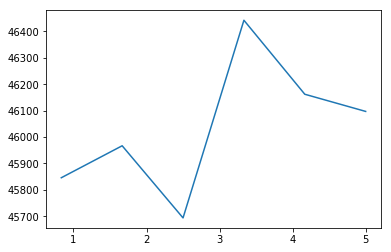

(array([45846, 45967, 45694, 46442, 46162, 46097]), array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
        4.16666667,  5.        ])) 276208


In [28]:
h = np.histogram(actions, bins=6)
plt.plot(h[1][1:], h[0])
plt.show()
print h, np.sum(h[0])

In [ ]:
f = file("rewards-2.dat", "w")
np.save(f, rewards)
f.close()

In [ ]:
f = file("V-matrix-2.dat", "w")
np.save(f, V)
f.close()

In [ ]:
saver = tf.train.Saver()


In [ ]:
saver.save(sess, "OpenAI-DemonAttack-v3-a7-2")

In [ ]:
f = file("checkpoints/V-matrix.dat")
V = np.load(f)
f.close()

In [ ]:
print V

In [ ]:
saver.restore(sess=sess, save_path="/home/martin/notebooks/checkpoints/OpenAI-DemonAttack-v3-a7")